### Achieved 99.47 accuracy  by using

1.Using less than 20,000 parameters

2.Achieved 99% accuracy within 4 epochs

3.Achieved 99.4 % accuracy in less than 14 epochs and with less than 20,000 parameters which means I successfully saved RAM (i.e Computation) and used correct Computer Vision Techniques for getting a good accuracy with less no of training loops.

In [21]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [6]:
# check if cuda is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device,"is being used")

cuda is being used


In [7]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([transforms.RandomRotation(10),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [18]:
#function for visualizing dataset
def imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [8]:
classes = (0,1,2,3,4,5,6,7,8,9)

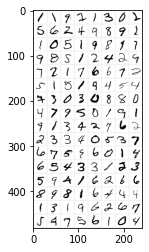

In [23]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
imshow(img_grid, one_channel=True)


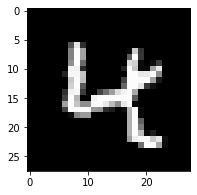

In [27]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
            #input-28x28x1
        self.conv1 = nn.Sequential(
            # RF - 3x3
            nn.Conv2d(1, 16, 3, bias=False),
            nn.ReLU(),          
            nn.BatchNorm2d(16),  
            nn.Dropout2d(0.1),

            #input-26x26x16
            # RF - 5x5
            nn.Conv2d(16, 16, 3, bias=False),                      
            nn.ReLU(), 
            nn.BatchNorm2d(16),          
            
            #input-24x24x16
            # RF - 7x7
            nn.Conv2d(16, 32, 3, bias=False),            
            nn.ReLU(),         
            nn.BatchNorm2d(32),  
            nn.Dropout2d(0.1),
        )

        
        #Transition block
        self.transition= nn.Sequential(
            #input-22x22x32
            nn.Conv2d(32,16,1),
            nn.ReLU(),

            nn.MaxPool2d(2, 2),
            #output=11x11x16
        )      

        self.conv2 = nn.Sequential(
            
            #input=11x11x16
            nn.Conv2d(16, 16, 3, bias=False), #RF=16x16          
            nn.ReLU(),          
            nn.BatchNorm2d(16),   
            nn.Dropout2d(0.1), 

            #input=9x9x16
            nn.Conv2d(16, 16, 3, padding=1, bias=False),        
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),
            
            nn.Conv2d(16, 16, 3,bias=False),               
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),
            
            #input=7x7x16
            nn.Conv2d(16,32, 3, bias=False),    
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),        

        )   #output=5x5x32

        self.conv_final=nn.Conv2d(32, 10, 1, bias=False)# input: 32x5x5, output: 32x1x1 
        self.gap = nn.AvgPool2d(5)            
            

    def forward(self, x):

        x= self.conv1(x)
        x=self.transition(x)
        x= self.conv2(x)      
        x=self.conv_final(x)
        x=self.gap(x)
        x=x.view(-1,10)        
        
        return F.log_softmax(x)

In [29]:
# model the model to the device
model = Net().to(device)
# print the model summary when given input_size
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
         Dropout2d-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
            Conv2d-8           [-1, 32, 22, 22]           4,608
              ReLU-9           [-1, 32, 22, 22]               0
      BatchNorm2d-10           [-1, 32, 22, 22]              64
        Dropout2d-11           [-1, 32, 22, 22]               0
           Conv2d-12           [-1, 16, 22, 22]             528
             ReLU-13           [-1, 16, 22, 22]               0
        MaxPool2d-14           [-1, 16,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [30]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [31]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


for epoch in range(1, 20):
    print('\nEpoch {} : '.format(epoch))
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 1 : 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0682, Accuracy: 9804/10000 (98.04%)


Epoch 2 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9880/10000 (98.80%)


Epoch 3 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9905/10000 (99.05%)


Epoch 4 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9912/10000 (99.12%)


Epoch 5 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9926/10000 (99.26%)


Epoch 6 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9914/10000 (99.14%)


Epoch 7 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9923/10000 (99.23%)


Epoch 8 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9927/10000 (99.27%)


Epoch 9 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99.36%)


Epoch 10 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9928/10000 (99.28%)


Epoch 11 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9933/10000 (99.33%)


Epoch 12 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9947/10000 (99.47%)


Epoch 13 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9945/10000 (99.45%)


Epoch 14 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9936/10000 (99.36%)


Epoch 15 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)


Epoch 16 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9932/10000 (99.32%)


Epoch 17 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9945/10000 (99.45%)


Epoch 18 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9944/10000 (99.44%)


Epoch 19 : 


loss=0.02507719397544861 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.17it/s]



Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.39%)



### Achieved 99.47 accuracy  by using
1.Batchnorm

2.Drop out of 0.1(i.e 10%)

3.Using less than 20,000 parameters

4.Achieved 99% accuracy within 4 epochs

5.Achieved 99.4 % accuracy in less than 14 epochs and with less than 20,000 parameters which means I successfully saved RAM (i.e Computation) and used correct Computer Vision Techniques for getting a good accuracy with less no of training loops.